In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from MaskedRNN import MaskedDeepRNN

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.figsize': (15, 8)})
sns.set_style('dark')
sns.set_palette('deep')

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

#### Import, shuffle and split dataset

In [0]:
data = pd.read_csv('test_data.csv')

In [6]:
print('Total length: {}'.format(len(data)))

Total length: 6250


#### Parameters

In [0]:
MODEL = 'rnn-relu'

In [0]:
INPUT_SIZE = 128
EMBEDDING_DIM = 100
OUTPUT_SIZE = 2

HIDDEN_LAYERS = [50, 50, 50]

#### Helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor.to(device))

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Model

In [0]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers: list, nonlinearity):
        super(Model, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_layers[0]).to(device)
        self.recurrent = MaskedDeepRNN(hidden_layers[0], hidden_layers, nonlinearity=nonlinearity).to(device)
        self.fc = nn.Linear(hidden_layers[-1], output_size).to(device)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)
        output = self.recurrent(embedded)
        return self.fc(output)

#### Train & Test

In [0]:
losses = pd.DataFrame()

In [0]:
def test(seq, target):
    input, seq_lengths, target = make_variables([seq], [target])
    output = model(input)
    loss = criterion(output, target)
    test_loss.append(loss)

In [16]:
%%time
for i in range(1, 6):
    print('Run: {}'.format(i))
    model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS, nonlinearity='relu').cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.load_state_dict(torch.load('./state_dicts/rnn-relu-dict-{}.pt'.format(i)))

    test_loss = []
    for l in range(len(data)):
        test(data['string'][l], data['valid'][l])

    losses['Run {}'.format(i)] = [_l.item() for _l in test_loss]

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
CPU times: user 4min 39s, sys: 4.26 s, total: 4min 43s
Wall time: 4min 44s


#### Plot and save

In [0]:
losses['str_len'] = data['string'].str.len()

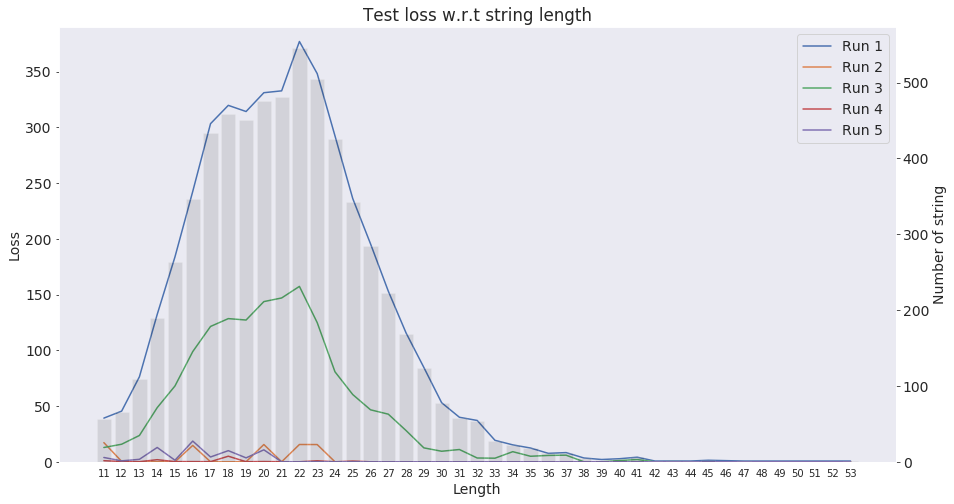

In [18]:
fig, ax1 = plt.subplots()
ax1.set_title('Test loss w.r.t string length')
ax1.set_xlabel('Length')
plt.xticks(range(11, 54), size=10)

ax1.set_ylabel('Loss')
ax1.set_ylim([0, 390])
for column in losses:
    if column != 'str_len':
        ax1.plot(losses.groupby(['str_len'])[column].sum(), label='Run {}'.format(column.split()[-1]))
ax1.tick_params(axis='y')
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Number of string')
ax2.bar(losses.groupby(['str_len'])['str_len'].count().index, losses.groupby(['str_len'])['str_len'].count().values, color='k', alpha=.1)
plt.savefig('./loss/{}-loss-len-dist.png'.format(MODEL));